# Finding pairs and tiles of EMIT/S2

## Dependencies

In [ ]:
!pip install -q numpy xarray rasterio shapely pyproj matplotlib panel holoviews hvplot tqdm jupyter_bokeh pystac-client earthaccess netCDF4 spectral rioxarray hvplot
!pip install -q "git+https://github.com/EnSpec/hytools.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.6/180.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/

In [ ]:
!git clone https://github.com/martasumyk/hyperspectral_super-resolution

Cloning into 'hyperspectral_super-resolution'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 174 (delta 85), reused 102 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (174/174), 3.98 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [ ]:
%cd /content/hyperspectral_super-resolution/

/content/hyperspectral_super-resolution


In [ ]:
!apt-get update
!apt-get install -y gdal-bin

!gdalwarp --version

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,564 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,633 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,858 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Get:14 http://arc

In [ ]:
import os, json, math
from pathlib import Path
from datetime import datetime, date, timezone, timedelta
from datetime import timezone
from pprint import pprint
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from rasterio.windows import Window, transform as win_transform



import numpy as np
import json
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from tqdm import tqdm

import panel as pn
import holoviews as hv
import hvplot.xarray

from pystac_client import Client

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from EMIT_data.emit_tools import emit_xarray
from s2_data.s2_utils import plot_s2_truecolor

from s2_data.s2_utils import (
    point_buffer_bbox, get_item_dt_utc, download_asset, plot_s2_truecolor, find_best_s2_for_date
)
from s2_data.cloud_utils import (
    find_asset_key, reproject_geom, scl_metrics, count_cloud_pixels
)

from EMIT_data.EMIT_utils import (
    login, search, download_reflectance, open_reflectance, attach_wavelengths
)
from EMIT_data.emit_tools import quality_mask, band_mask
from EMIT_data.emit_proj import nc_to_envi
from EMIT_data.viz import show_emit_rgb_from_envi

pn.extension("tabulator")
hv.extension("bokeh")


## Earthdata login

Login to https://urs.earthdata.nasa.gov/.

In [ ]:
login(persist=True)

Enter your Earthdata Login username: martasumyk
Enter your Earthdata password: ··········


## Parameters

In [ ]:
LAT = 24
LON = 42

SEARCH_BUFFER_M = 20_000  # meters radius around point

In [ ]:
S2_API = "https://earth-search.aws.element84.com/v1"
S2_COLLECTION = "sentinel-2-l2a"

Date window:

In [ ]:
from datetime import date
DATE_START = date(2022, 1, 1)
DATE_END = date.today()

Cloud thresholds:

In [ ]:
MAX_S2_CLOUD_FRAC = 50.0
MAX_EMIT_CLOUD_PCT = 50.0

Output folders:

In [ ]:
ROOT = Path("pairs_output")
EMIT_DIR = ROOT / "emit"
S2_DIR   = ROOT / "s2"
ENVI_DIR = ROOT / "envi"
FIG_DIR  = ROOT / "figures"
for p in (EMIT_DIR, S2_DIR, ENVI_DIR, FIG_DIR):
    p.mkdir(parents=True, exist_ok=True)

## Helpers

In [ ]:
def _emit_item_date(item) -> date:
    """Extract UTC date from an EMIT search item."""
    try:
        iso = item["umm"]["ProviderDates"][0]["Date"]
    except Exception:
        iso = item.get("datetime") or item.get("start_time")
    dt_utc = datetime.fromisoformat(str(iso).replace("Z", "+00:00")).astimezone(timezone.utc)
    return dt_utc.date()

def _emit_cloud_pct(item) -> float:
    try:
        return float(item["umm"].get("CloudCover"))
    except Exception:
        return float("inf")

def find_emit_candidates(lon: float, lat: float):
    """Search EMIT around the location and within DATE_START..DATE_END."""
    login(persist=True)
    roi_bbox = point_buffer_bbox(lon, lat, SEARCH_BUFFER_M)
    items = search(
        point=(lon, lat),
        bbox=roi_bbox,
        start=DATE_START.isoformat(),
        end=DATE_END.isoformat(),
    )
    return list(items)

def choose_best_emit_per_date(items):
    """Group by date and keep least-cloudy EMIT per date; apply optional max cloud threshold."""
    by_date = {}
    for it in items:
        d = _emit_item_date(it)
        cur = by_date.get(d)
        if cur is None or _emit_cloud_pct(it) < _emit_cloud_pct(cur):
            by_date[d] = it
    if MAX_EMIT_CLOUD_PCT is not None:
        by_date = {d: it for d, it in by_date.items() if _emit_cloud_pct(it) <= MAX_EMIT_CLOUD_PCT}
    return {d.isoformat(): it for d, it in by_date.items()}


def download_s2_truecolor(item) -> Path:
    """Download S2 visual (true color) if available; else save B04/B03/B02 and return JSON list."""
    assets = item.assets
    if "visual" in assets:
        href = assets["visual"].href
        out = S2_DIR / f"{item.id}_visual.tif"
        if not out.exists():
            download_asset(href, out)
        return out
    band_paths = []
    for b in ("B04", "B03", "B02"):
        if b in assets:
            href = assets[b].href
            out = S2_DIR / f"{item.id}_{b}.tif"
            if not out.exists():
                download_asset(href, out)
            band_paths.append(str(out))
    out_json = S2_DIR / f"{item.id}_RGB_bands.json"
    out_json.write_text(json.dumps(band_paths, indent=2))
    return out_json


def convert_emit_nc_to_envi(emit_nc_paths, s2_visual_path, out_dir, emit_obs_nc=None) -> Path:
    """
    Run nc_to_envi and return the path to the RFL ENVI .bin cube.

    emit_nc_paths : list[Path] or similar from download_reflectance
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    tmp_dir = out_dir / "tmp"
    tmp_dir.mkdir(parents=True, exist_ok=True)

    print(emit_nc_paths[0])
    nc_to_envi(
        img_file=str(emit_nc_paths[0]),
        out_dir=str(out_dir),
        temp_dir=str(tmp_dir),
        obs_file=str(emit_obs_nc) if emit_obs_nc else None,
        export_loc=True,
        crid="000",
        s2_tif_path=str(s2_visual_path),
        match_res=False,
        write_xml=False,
    )

    # hytools usually writes into out_dir / "emit_out"
    emit_out = out_dir / "emit_out"
    search_root = emit_out if emit_out.exists() else out_dir

    # Look for the reflectance cube
    for pattern in ("*RFL*000.bin", "*RFL*.bin", "*.bin"):
        bins = sorted(search_root.glob(pattern))
        if bins:
            print("Picked ENVI cube:", bins[0])
            return bins[0]

    raise FileNotFoundError(f"ENVI .bin not found under {search_root}")



def visualize_pair(date_iso: str, s2_path: Path, envi_bin_path: Path) -> Path:
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # --- S2 side ---
    try:
        # s2_path can be a visual.tif or a JSON with band paths
        if isinstance(s2_path, Path) and s2_path.suffix.lower() == ".json":
            s2_paths = json.loads(s2_path.read_text())
        else:
            s2_paths = [str(s2_path)]

        plot_s2_truecolor(s2_paths, ax=ax1)
    except Exception as e:
        ax1.text(0.5, 0.5, f"S2 plot failed: {e}", ha="center", va="center")
        ax1.set_axis_off()

    # --- EMIT side ---
    try:
        show_emit_rgb_from_envi_ax(envi_bin_path, ax=ax2, gamma=1.0)
    except Exception as e:
        ax2.text(0.5, 0.5, f"EMIT plot failed: {e}", ha="center", va="center")
        ax2.set_axis_off()

    out_png = FIG_DIR / f"pair_{date_iso}.png"
    fig.tight_layout()
    fig.savefig(out_png, dpi=150)
    plt.close(fig)
    return out_png



## Inference (finding cloud-free pairs)

In [ ]:
roi_bbox = point_buffer_bbox(LON, LAT, SEARCH_BUFFER_M)
print("ROI BBOX:", roi_bbox)

ROI BBOX: POLYGON ((42.196283406514155 23.819298860580307, 42.19683193361432 24.180444925521233, 41.80316806638569 24.180444925521233, 41.80371659348585 23.819298860580307, 42.196283406514155 23.819298860580307))


In [ ]:
picks = search(point=(LON, LAT), bbox = roi_bbox.bounds, buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,100.0))
emit_by_date = choose_best_emit_per_date(picks)
print(f"Found {len(emit_by_date)} EMIT dates")

Found 26 granule(s).
Found 17 EMIT dates


In [ ]:
pairs = []
for d_iso, emit_item in emit_by_date.items():
    s2_item, s2_cloud = find_best_s2_for_date(d_iso, LON, LAT, S2_COLLECTION, SEARCH_BUFFER_M, S2_API, S2_DIR)
    if s2_item is None:
        continue
    if (s2_cloud is None) or (s2_cloud > MAX_S2_CLOUD_FRAC):
        continue
    pairs.append({
        "date": d_iso,
        "emit": emit_item,
        "emit_cloud_pct": _emit_cloud_pct(emit_item),
        "s2": s2_item,
        "s2_cloud_frac": s2_cloud,
    })

print(f"Kept {len(pairs)} EMIT/S2 same-day pairs after cloud filtering.")

S2 cloud check 2023-08-21:   0%|          | 0/3 [00:00<?, ?it/s]
S2B_37QGG_20230821_0_L2A_SCL.tif:   0%|          | 0.00/182k [00:00<?, ?B/s]
S2B_37QGG_20230821_0_L2A_SCL.tif: 100%|██████████| 182k/182k [00:00<00:00, 873kB/s]
S2 cloud check 2023-08-21:  33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]
S2B_37QHG_20230821_0_L2A_SCL.tif:   0%|          | 0.00/397k [00:00<?, ?B/s]
S2B_37QHG_20230821_0_L2A_SCL.tif: 100%|██████████| 397k/397k [00:00<00:00, 1.43MB/s]
S2 cloud check 2023-08-21:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]
S2B_38QKM_20230821_0_L2A_SCL.tif:   0%|          | 0.00/397k [00:00<?, ?B/s]
S2B_38QKM_20230821_0_L2A_SCL.tif: 100%|██████████| 397k/397k [00:00<00:00, 1.44MB/s]
S2 cloud check 2023-08-29:   0%|          | 0/2 [00:00<?, ?it/s]
S2A_37QGG_20230829_0_L2A_SCL.tif:   0%|          | 0.00/231k [00:00<?, ?B/s]
S2A_37QGG_20230829_0_L2A_SCL.tif: 100%|██████████| 231k/231k [00:00<00:00, 1.11MB/s]
S2 cloud check 2023-08-29:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s]
S2A_

Kept 3 EMIT/S2 same-day pairs after cloud filtering.


## Plot one pair

Just one pair:

In [ ]:
pair = pairs[0]
emit_item = pair["emit"]
s2_item   = pair["s2"]
print(pair["date"], pair["emit_cloud_pct"], pair["s2_cloud_frac"])

2023-08-21 0.0 0.0


In [ ]:
from pathlib import Path

emit_paths = download_reflectance(emit_item, str(EMIT_DIR), assets=["_RFL_"])
emit_nc = Path(emit_paths[0])
print("EMIT file:", emit_nc)


Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

EMIT file: pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc


In [ ]:
s2_tif = download_s2_truecolor(s2_item)
print("S2 file:", s2_tif)

S2B_37QGG_20230821_0_L2A_visual.tif: 100%|██████████| 114M/114M [00:04<00:00, 23.8MB/s]

S2 file: pairs_output/s2/S2B_37QGG_20230821_0_L2A_visual.tif


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio



def _nearest_band_indices(wavelengths, targets_nm):
    """Return indices in `wavelengths` nearest to each nm in `targets_nm`."""
    wl = np.asarray(wavelengths, dtype=float)
    idxs, picked = [], []
    for t in targets_nm:
        i = int(np.argmin(np.abs(wl - float(t))))
        idxs.append(i)
        picked.append(wl[i])
        print(f"Picked band {i} at {wl[i]:.1f} nm for target {t:.1f} nm")
    return idxs, picked

def _percentile_stretch(img, p_low=2, p_high=98):
    """Apply per-channel percentile stretch to 0..1."""
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)
    if img.ndim == 3:
        for c in range(3):
            ch = img[..., c]
            finite = np.isfinite(ch)
            if not np.any(finite):
                continue
            lo, hi = np.percentile(ch[finite], (p_low, p_high))
            if hi <= lo:
                continue
            out[..., c] = np.clip((ch - lo) / (hi - lo), 0, 1)
    else:
        finite = np.isfinite(img)
        if np.any(finite):
            lo, hi = np.percentile(img[finite], (p_low, p_high))
            if hi > lo:
                out = np.clip((img - lo) / (hi - lo), 0, 1)
    return out

def _parse_wavelengths_from_tags(tags: dict):
    """
    ENVI stores wavelengths as a header key like:
      'wavelength': '{ 400.0, 401.0, ... }'
    This parses it into a list[float]. Returns None if absent.
    """
    w_txt = tags.get('wavelength') or tags.get('WAVELENGTH')
    if not w_txt:
        return None
    # normalize to Python list literal
    w_txt = w_txt.strip()
    if w_txt.startswith('{') and w_txt.endswith('}'):
        w_txt = '[' + w_txt[1:-1] + ']'
    # remove potential line breaks, duplicate spaces
    w_txt = re.sub(r'\s+', ' ', w_txt)
    try:
        vals = ast.literal_eval(w_txt)
        return [float(v) for v in vals]
    except Exception:
        return None


def show_emit_rgb_from_envi(out_dir,
                            pattern="SISTER_EMIT_L2A_RFL_*_000.bin",
                            targets_nm=(630.0, 532.0, 465.0),
                            percentile=(2, 98),
                            gamma=1/2.2,
                            white_balance=True,
                            ax=None):
    """
    Find the EMIT RFL ENVI output in out_dir and display an RGB.

    If `ax` is provided, the image is drawn on that axes (e.g. for subplots).
    If `ax` is None, a new figure and axes are created.
    """
    # 1) pick file
    bins = sorted(glob.glob(os.path.join(out_dir, pattern)))
    if not bins:
        raise FileNotFoundError(f"No files matching {pattern} in {out_dir}")
    data_bin = bins[-1]  # latest
    print(f"Reading: {os.path.basename(data_bin)}")

    # 2) open with rasterio, read metadata + bands
    with rasterio.open(data_bin) as ds:
        # wavelengths from header tags (file-level)
        tags = ds.tags()
        wavelengths = _parse_wavelengths_from_tags(tags)
        if wavelengths is None:
            # sometimes wavelengths end up as per-band tags; try that
            wavelengths = []
            for b in range(1, ds.count+1):
                bt = ds.tags(b)
                w = bt.get('wavelength') or bt.get('WAVELENGTH')
                wavelengths.append(float(w) if w else np.nan)
            if not np.isfinite(wavelengths).any():
                raise ValueError("No wavelengths found in ENVI header tags.")

        idxs, picked = _nearest_band_indices(wavelengths, targets_nm)
        # rasterio bands are 1-based
        R = ds.read(idxs[0] + 1).astype(np.float32)
        G = ds.read(idxs[1] + 1).astype(np.float32)
        B = ds.read(idxs[2] + 1).astype(np.float32)

        # 3) handle nodata and reflectance scaling (EMIT reflectance should be 0..1)
        nodata = ds.nodata
        if nodata is not None:
            for arr in (R, G, B):
                arr[arr == nodata] = np.nan

        # clip extreme outliers (safety), then percentile-stretch
        rgb = np.dstack([np.clip(R, 0, 1),
                         np.clip(G, 0, 1),
                         np.clip(B, 0, 1)])

        rgb = _percentile_stretch(rgb, *percentile)

        if white_balance:
            means = np.nanmean(rgb.reshape(-1, 3), axis=0)
            scale = np.nanmean(means) / np.maximum(means, 1e-6)
            rgb = np.clip(rgb * scale, 0, 1)

        rgb_disp = np.clip(rgb, 0, 1) ** gamma

        # 4) plot
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
            created_fig = True

        ax.imshow(rgb_disp, origin="upper")
        epsg = ds.crs.to_string() if ds.crs else "unknown CRS"
        ax.set_title(f"EMIT True Color ~ {picked[0]:.0f}/{picked[1]:.0f}/{picked[2]:.0f} nm\n{epsg}")
        ax.axis("off")

        if created_fig:
            plt.show()


pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc
pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc
Opened EMIT image dataset: pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc
Disabling auto mask/scale for variable 'reflectance'
Exporting EMIT L2A_RFL dataset
Projecting data to EPSG:32637 (60 m)
Exporting EMIT location dataset
Projecting location datacube to EPSG:32637 (60 m)
Picked ENVI cube: pairs_output/emit/SISTER_EMIT_L2A_RFL_20230819T110126_000.bin
Reading: SISTER_EMIT_L2A_RFL_20230819T110126_000.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


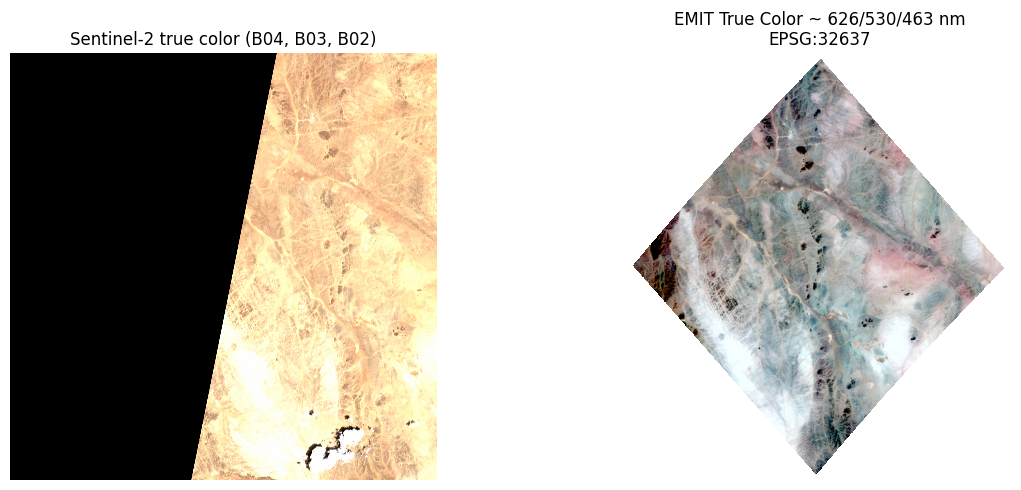

In [ ]:
pair = pairs[0]

# # download EMIT reflectance
# emit_paths = download_reflectance(pair["emit"], str(EMIT_DIR), assets=["_RFL_"])
# emit_nc = emit_paths[0]
# print("Emit file:", emit_nc)

# # download S2 visual/truecolor
# s2_tif = download_s2_truecolor(pair["s2"])
# print("S2 file:", s2_tif)

if isinstance(s2_tif, Path) and s2_tif.suffix.lower() == ".tif":
        out_dir = ROOT / f"emit"
        envi_bin = convert_emit_nc_to_envi(emit_paths, s2_tif, out_dir)
else:
    out_dir = ENVI_DIR / f"emit_{d_iso}"
    out_dir.mkdir(parents=True, exist_ok=True)
    envi_bin = None

# plot
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_s2_truecolor([str(s2_tif)], ax=ax1)
path_new = "/content/hyperspectral_super-resolution/" + str(envi_bin)
show_emit_rgb_from_envi(out_dir, pattern=path_new, ax=ax2, gamma=1/2.2)

plt.tight_layout()
plt.show()


In [ ]:
import rasterio
from rasterio.warp import transform
from pyproj import CRS

def print_raster_geometry(name, path):
    with rasterio.open(path) as ds:
        b = ds.bounds
        crs = ds.crs
        transform_aff = ds.transform

        # Corners in raster CRS (UTM for S2 & EMIT)
        corners_utm = {
            "UL": (b.left,  b.top),     # upper-left
            "UR": (b.right, b.top),     # upper-right
            "LR": (b.right, b.bottom),  # lower-right
            "LL": (b.left,  b.bottom)   # lower-left
        }

        # Center in raster CRS
        center_utm = ((b.left + b.right) / 2, (b.top + b.bottom) / 2)

        # Convert to WGS84
        xs = [p[0] for p in corners_utm.values()] + [center_utm[0]]
        ys = [p[1] for p in corners_utm.values()] + [center_utm[1]]

        lon, lat = transform(crs, CRS.from_epsg(4326), xs, ys)
        corners_wgs84 = {k: (lon[i], lat[i]) for i, k in enumerate(corners_utm.keys())}
        center_wgs84 = (lon[-1], lat[-1])

    print(f"\n==============================")
    print(f"{name} — Geometry")
    print(f"File: {path}")
    print(f"CRS:  {crs}")
    print("------------------------------")

    print("Corners (UTM):")
    for k, v in corners_utm.items():
        print(f"  {k}: {v}")

    print("\nCorners (WGS84):")
    for k, v in corners_wgs84.items():
        print(f"  {k}: (lon={v[0]:.6f}, lat={v[1]:.6f})")

    print("\nCenter (UTM):", center_utm)
    print("Center (WGS84): (lon=%.6f, lat=%.6f)" % center_wgs84)
    print("==============================\n")


# 🔹 Print S2 tile geometry
print_raster_geometry("SENTINEL-2", s2_tif)

# 🔹 Print EMIT tile geometry
print_raster_geometry("EMIT", envi_bin)



SENTINEL-2 — Geometry
File: pairs_output/s2/S2B_37QGG_20230821_0_L2A_visual.tif
CRS:  EPSG:32637
------------------------------
Corners (UTM):
  UL: (699960.0, 2700000.0)
  UR: (809760.0, 2700000.0)
  LR: (809760.0, 2590200.0)
  LL: (699960.0, 2590200.0)

Corners (WGS84):
  UL: (lon=40.971855, lat=24.400586)
  UR: (lon=42.053629, lat=24.382631)
  LR: (lon=42.030450, lat=23.392275)
  LL: (lon=40.956871, lat=23.409414)

Center (UTM): (754860.0, 2645100.0)
Center (WGS84): (lon=41.503201, lat=23.897187)


EMIT — Geometry
File: pairs_output/emit/SISTER_EMIT_L2A_RFL_20230819T110126_000.bin
CRS:  EPSG:32637
------------------------------
Corners (UTM):
  UL: (730364.415176879, 2707066.59325712)
  UR: (841904.415176879, 2707066.59325712)
  LR: (841904.415176879, 2582746.59325712)
  LL: (730364.415176879, 2582746.59325712)

Corners (WGS84):
  UL: (lon=41.272651, lat=24.460160)
  UR: (lon=42.371794, lat=24.439630)
  LR: (lon=42.342844, lat=23.318654)
  LL: (lon=41.253114, lat=23.338131)

Center

In [ ]:
import rasterio
from rasterio.windows import from_bounds, transform as win_transform

def crop_to_overlap(s2_path, emit_path, out_s2_path, out_emit_path):
    # Open both rasters
    with rasterio.open(s2_path) as s2_ds, rasterio.open(emit_path) as emit_ds:
        # 1) Check CRS
        if s2_ds.crs != emit_ds.crs:
            raise ValueError(f"CRS mismatch: {s2_ds.crs} != {emit_ds.crs}. Reproject first.")

        # 2) Overlap in UTM
        s2_b = s2_ds.bounds
        e_b  = emit_ds.bounds

        left   = max(s2_b.left,   e_b.left)
        right  = min(s2_b.right,  e_b.right)
        bottom = max(s2_b.bottom, e_b.bottom)
        top    = min(s2_b.top,    e_b.top)

        if not (left < right and bottom < top):
            raise ValueError("No overlap between S2 and EMIT extents.")

        overlap_bounds = (left, bottom, right, top)
        print("Overlap bounds (UTM):", overlap_bounds)

        # 3) Windows
        s2_win   = from_bounds(*overlap_bounds, transform=s2_ds.transform)
        emit_win = from_bounds(*overlap_bounds, transform=emit_ds.transform)

        # 4) Read cropped data
        s2_data   = s2_ds.read(window=s2_win)
        emit_data = emit_ds.read(window=emit_win)

        # 5) Profiles
        s2_profile = s2_ds.profile.copy()
        s2_profile.update({
            "height": s2_win.height,
            "width":  s2_win.width,
            "transform": win_transform(s2_win, s2_ds.transform),
        })

        emit_profile = emit_ds.profile.copy()
        emit_profile.update({
            "height": emit_win.height,
            "width":  emit_win.width,
            "transform": win_transform(emit_win, emit_ds.transform),
        })

        # 🔹 copy ENVI/EMIT metadata tags (including wavelengths!)
        emit_tags = emit_ds.tags()

    # 6) Write cropped rasters
    with rasterio.open(out_s2_path, "w", **s2_profile) as dst:
        dst.write(s2_data)

    with rasterio.open(out_emit_path, "w", **emit_profile) as dst:
        dst.write(emit_data)
        dst.update_tags(**emit_tags)   # <-- critical

    print("Saved:")
    print("  S2  cropped ->", out_s2_path)
    print("  EMIT cropped ->", out_emit_path)


In [ ]:
import rasterio

with rasterio.open(s2_tif) as s2_ds, rasterio.open(envi_bin) as emit_ds:
    print("S2 CRS:   ", s2_ds.crs)
    print("EMIT CRS: ", emit_ds.crs)


S2 CRS:    EPSG:32637
EMIT CRS:  EPSG:32637


In [ ]:
import rasterio
from rasterio.windows import from_bounds, transform as win_transform

def crop_to_overlap(s2_path, emit_path, out_s2_path, out_emit_path):
    with rasterio.open(s2_path) as s2_ds, rasterio.open(emit_path) as emit_ds:
        # 1) CRS check
        if s2_ds.crs != emit_ds.crs:
            raise ValueError(f"CRS mismatch: {s2_ds.crs} != {emit_ds.crs}. Reproject EMIT first.")

        # 2) Обчислюємо спільний прямокутник (в UTM метрах)
        s2_b = s2_ds.bounds
        e_b  = emit_ds.bounds

        left   = max(s2_b.left,   e_b.left)
        right  = min(s2_b.right,  e_b.right)
        bottom = max(s2_b.bottom, e_b.bottom)
        top    = min(s2_b.top,    e_b.top)

        if not (left < right and bottom < top):
            raise ValueError("No overlap between S2 and EMIT extents.")

        overlap_bounds = (left, bottom, right, top)
        print("Overlap bounds (UTM):", overlap_bounds)

        # 3) Вікна по цих межах
        s2_win   = from_bounds(*overlap_bounds, transform=s2_ds.transform)
        emit_win = from_bounds(*overlap_bounds, transform=emit_ds.transform)

        # 4) Читаємо дані
        s2_data   = s2_ds.read(window=s2_win)
        emit_data = emit_ds.read(window=emit_win)

        # 5) Оновлені профілі
        s2_profile = s2_ds.profile.copy()
        s2_profile.update({
            "height": s2_win.height,
            "width":  s2_win.width,
            "transform": win_transform(s2_win, s2_ds.transform),
        })

        emit_profile = emit_ds.profile.copy()
        emit_profile.update({
            "height": emit_win.height,
            "width":  emit_win.width,
            "transform": win_transform(emit_win, emit_ds.transform),
        })

        emit_tags = emit_ds.tags()

    # 6) Пишемо кропнуті файли
    with rasterio.open(out_s2_path, "w", **s2_profile) as dst:
        dst.write(s2_data)

    with rasterio.open(out_emit_path, "w", **emit_profile) as dst:
        dst.write(emit_data)
        dst.update_tags(**emit_tags)

    print("Saved:")
    print("  S2  cropped  ->", out_s2_path)
    print("  EMIT cropped ->", out_emit_path)


In [ ]:
out_s2   = S2_DIR   / f"{pair['date']}_s2_overlap.tif"
out_emit = EMIT_DIR / f"{pair['date']}_emit_overlap.bin"

In [ ]:
crop_to_overlap(
    s2_path=s2_tif,
    emit_path=envi_bin,
    out_s2_path=str(out_s2),
    out_emit_path=str(out_emit),
)


Overlap bounds (UTM): (730364.415176879, 2590200.0, 809760.0, 2700000.0)


Saved:
  S2  cropped  -> pairs_output/s2/2023-08-21_s2_overlap.tif
  EMIT cropped -> pairs_output/emit/2023-08-21_emit_overlap.bin


In [ ]:
import rasterio
from rasterio.windows import from_bounds, transform as win_transform

def crop_to_overlap(s2_path, emit_path, out_s2_path, out_emit_path):
    with rasterio.open(s2_path) as s2_ds, rasterio.open(emit_path) as emit_ds:
        # 1) CRS check
        if s2_ds.crs != emit_ds.crs:
            raise ValueError(f"CRS mismatch: {s2_ds.crs} != {emit_ds.crs}. Reproject first.")

        # 2) Bounds intersection
        s2_b = s2_ds.bounds
        e_b  = emit_ds.bounds

        left   = max(s2_b.left,   e_b.left)
        right  = min(s2_b.right,  e_b.right)
        bottom = max(s2_b.bottom, e_b.bottom)
        top    = min(s2_b.top,    e_b.top)

        print("S2 bounds:  ", s2_b)
        print("EMIT bounds:", e_b)
        print("Overlap candidate:", (left, bottom, right, top))

        if not (left < right and bottom < top):
            raise ValueError("No overlap between S2 and EMIT extents.")

        overlap_bounds = (left, bottom, right, top)
        print("Overlap bounds (UTM):", overlap_bounds)

        # 3) Windows
        s2_win   = from_bounds(*overlap_bounds, transform=s2_ds.transform)
        emit_win = from_bounds(*overlap_bounds, transform=emit_ds.transform)

        # 4) Read overlap data
        s2_data   = s2_ds.read(window=s2_win)
        emit_data = emit_ds.read(window=emit_win)

        # 5) Profiles
        s2_profile = s2_ds.profile.copy()
        s2_profile.update({
            "height": s2_win.height,
            "width":  s2_win.width,
            "transform": win_transform(s2_win, s2_ds.transform),
        })

        emit_profile = emit_ds.profile.copy()
        emit_profile.update({
            "height": emit_win.height,
            "width":  emit_win.width,
            "transform": win_transform(emit_win, emit_ds.transform),
        })

        # 🔹 save EMIT tags (dataset + per-band) so wavelengths survive
        emit_ds_tags   = emit_ds.tags()
        emit_band_tags = [emit_ds.tags(i) for i in range(1, emit_ds.count + 1)]

    # 6) Write overlaps
    with rasterio.open(out_s2_path, "w", **s2_profile) as dst:
        dst.write(s2_data)

    with rasterio.open(out_emit_path, "w", **emit_profile) as dst:
        dst.write(emit_data)
        dst.update_tags(**emit_ds_tags)
        for i, bt in enumerate(emit_band_tags, start=1):
            if bt:
                dst.update_tags(i, **bt)

    print("Saved overlap:")
    print("  S2  ->", out_s2_path)
    print("  EMIT->", out_emit_path)

    return out_s2_path, out_emit_path


In [ ]:
out_s2_overlap   = S2_DIR   / f"{pair['date']}_s2_overlap.tif"
out_emit_overlap = EMIT_DIR / f"{pair['date']}_emit_overlap.bin"

out_s2_overlap, out_emit_overlap = crop_to_overlap(
    s2_path=s2_tif,
    emit_path=envi_bin,
    out_s2_path=str(out_s2_overlap),
    out_emit_path=str(out_emit_overlap),
)


S2 bounds:   BoundingBox(left=699960.0, bottom=2590200.0, right=809760.0, top=2700000.0)
EMIT bounds: BoundingBox(left=730364.415176879, bottom=2582746.59325712, right=841904.415176879, top=2707066.59325712)
Overlap candidate: (730364.415176879, 2590200.0, 809760.0, 2700000.0)
Overlap bounds (UTM): (730364.415176879, 2590200.0, 809760.0, 2700000.0)


Saved overlap:
  S2  -> pairs_output/s2/2023-08-21_s2_overlap.tif
  EMIT-> pairs_output/emit/2023-08-21_emit_overlap.bin


Reading: 2023-08-21_emit_overlap.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


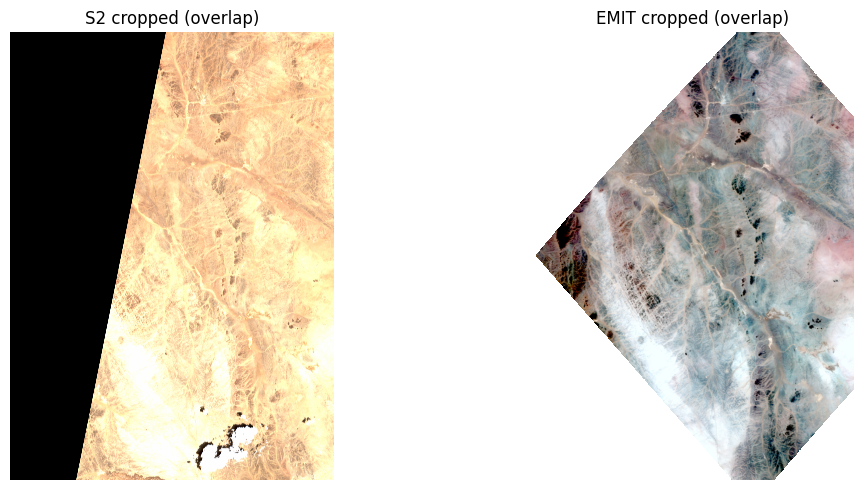

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 🔹 S2 cropped overlap
plot_s2_truecolor([str(out_s2_overlap)], ax=ax1)
ax1.set_title("S2 cropped (overlap)")
ax1.axis("off")

# 🔹 EMIT cropped overlap
emit_dir  = str(Path(out_emit_overlap).parent)
emit_name = Path(out_emit_overlap).name   # only filename, NOT full path

show_emit_rgb_from_envi(
    out_dir=emit_dir,
    pattern=emit_name,
    ax=ax2,
    gamma=1/2.2,
)
ax2.set_title("EMIT cropped (overlap)")
ax2.axis("off")

plt.tight_layout()
plt.show()


## Tiles

To filter out black pixels:

In [ ]:
def compute_invalid_mask(tile, nodata, zero_threshold=1e-6):
    """
    tile: (bands, H, W)

    Returns mask (H, W) where pixels are considered invalid:
      - all bands ~= nodata, OR
      - all bands are very close to 0
    """
    if nodata is not None:
        is_nodata = np.all(np.isclose(tile, nodata, atol=zero_threshold), axis=0)
    else:
        is_nodata = np.zeros(tile.shape[1:], dtype=bool)

    is_zero = np.all(np.abs(tile) < zero_threshold, axis=0)
    invalid = is_nodata | is_zero
    return invalid


In [ ]:
def make_paired_tiles(
    emit_path,
    s2_path,
    out_root,
    emit_tile_size=100,
    overlap_frac=0.1,
    max_invalid_frac=1,
    zero_threshold=1e-6,
):
    """
    Create paired tiles:
      - EMIT tile: emit_tile_size x emit_tile_size   (e.g. 100 x 100)
      - S2 tile:   (emit_tile_size * scale)²        (e.g. 600 x 600 if scale=6)

    overlap_frac: e.g., 0.1 -> 10% overlap → stride = 0.9 * tile size
    max_invalid_frac: max fraction of invalid (black/nodata) pixels allowed
                      separately for EMIT and S2. If either exceeds this threshold,
                      the tile is skipped.
    """
    out_root = Path(out_root)
    out_emit_dir = out_root / "emit_tiles"
    out_s2_dir   = out_root / "s2_tiles"
    out_emit_dir.mkdir(parents=True, exist_ok=True)
    out_s2_dir.mkdir(parents=True, exist_ok=True)

    with rasterio.open(emit_path) as e_ds, rasterio.open(s2_path) as s_ds:
        assert e_ds.crs == s_ds.crs, "CRS mismatch between EMIT and S2"

        e_res = abs(e_ds.transform.a)
        s_res = abs(s_ds.transform.a)

        scale_float = e_res / s_res
        scale = int(round(scale_float))
        print(f"Pixel sizes: EMIT={e_res}, S2={s_res}, scale≈{scale_float:.2f}")

        if scale <= 0 or abs(scale_float - scale) > 0.1:
            raise ValueError(
                f"EMIT/S2 resolutions not a near-integer factor (got {scale_float:.2f}). "
                "Check that EMIT is coarser than S2."
            )

        s2_tile_size = emit_tile_size * scale

        emit_stride = int(emit_tile_size * (1 - overlap_frac))
        s2_stride   = emit_stride * scale

        e_h, e_w = e_ds.height, e_ds.width
        s_h, s_w = s_ds.height, s_ds.width

        print(f"EMIT size: {e_w} x {e_h}")
        print(f"S2   size: {s_w} x {s_h}")
        print(f"Tile sizes: EMIT={emit_tile_size}, S2={s2_tile_size}")
        print(f"Strides:    EMIT={emit_stride}, S2={s2_stride}")
        print(f"max_invalid_frac={max_invalid_frac}")

        emit_nodata = e_ds.nodata
        s2_nodata   = s_ds.nodata

        emit_ds_tags   = e_ds.tags()
        emit_band_tags = [e_ds.tags(i) for i in range(1, e_ds.count + 1)]
        s2_ds_tags     = s_ds.tags()

        tile_id = 0
        kept = 0

        for er in range(0, e_h - emit_tile_size + 1, emit_stride):
            for ec in range(0, e_w - emit_tile_size + 1, emit_stride):
                sr = er * scale
                sc = ec * scale

                if sr + s2_tile_size > s_h or sc + s2_tile_size > s_w:
                    tile_id += 1
                    continue

                emit_win = Window(ec, er, emit_tile_size, emit_tile_size)
                s2_win   = Window(sc, sr, s2_tile_size, s2_tile_size)

                emit_tile = e_ds.read(window=emit_win)   # (bands, 100, 100)
                s2_tile   = s_ds.read(window=s2_win)     # (bands, 600, 600)

                inv_emit = compute_invalid_mask(emit_tile, emit_nodata, zero_threshold)
                inv_s2   = compute_invalid_mask(s2_tile, s2_nodata, zero_threshold)

                invalid_emit_frac = float(inv_emit.mean())
                invalid_s2_frac   = float(inv_s2.mean())

                if (invalid_emit_frac > max_invalid_frac) or (invalid_s2_frac > max_invalid_frac):
                    tile_id += 1
                    continue

                emit_profile = e_ds.profile.copy()
                emit_profile.update({
                    "height": emit_tile_size,
                    "width":  emit_tile_size,
                    "transform": win_transform(emit_win, e_ds.transform),
                })

                emit_fname = out_emit_dir / f"emit_tile_{tile_id:05d}.bin"
                with rasterio.open(emit_fname, "w", **emit_profile) as dst:
                    dst.write(emit_tile)
                    dst.update_tags(**emit_ds_tags)
                    for i, bt in enumerate(emit_band_tags, start=1):
                        if bt:
                            dst.update_tags(i, **bt)

                s2_profile = s_ds.profile.copy()
                s2_profile.update({
                    "height": s2_tile_size,
                    "width":  s2_tile_size,
                    "transform": win_transform(s2_win, s_ds.transform),
                })

                s2_fname = out_s2_dir / f"s2_tile_{tile_id:05d}.tif"
                with rasterio.open(s2_fname, "w", **s2_profile) as dst:
                    dst.write(s2_tile)
                    dst.update_tags(**s2_ds_tags)

                kept += 1
                tile_id += 1

        print(f"Done. Kept {kept} tiles (max_invalid_frac={max_invalid_frac}).")
        return out_emit_dir, out_s2_dir


In [ ]:
emit_for_tiling = out_emit_overlap
s2_for_tiling   = out_s2_overlap

tiles_root = ROOT / "tiles"

emit_tiles_dir, s2_tiles_dir = make_paired_tiles(
    emit_path=str(emit_for_tiling),
    s2_path=str(s2_for_tiling),
    out_root=tiles_root,
    emit_tile_size=100,
    overlap_frac=0.1,     # 10% overlap
    max_invalid_frac=0.8,
)


In [ ]:
import numpy as np
import rasterio
from rasterio.windows import Window
from pathlib import Path

def is_black_mask(arr, nodata=None):
    """
    arr: (bands, H, W)
    Returns a boolean (H, W) mask where pixels are 'black'.
    - If nodata is given: pixel is black if *all* bands == nodata
    - Else: pixel is black if *all* bands == 0
    """
    if nodata is not None:
        return np.all(arr == nodata, axis=0)
    else:
        return np.all(arr == 0, axis=0)


def find_valid_paired_tiles(
    emit_path,
    s2_path,
    emit_tile_size=100,
    scale=6,
    max_black_frac=0.0,
    max_tiles=None
):
    """
    Iterate over EMIT and S2 in paired tiles.
    Assumes:
      - EMIT and S2 cover the same area
      - spatial resolution ratio = `scale` (S2 is finer)
      - S2 height/width ≈ scale * EMIT height/width
    Returns a list of tile descriptors:
      [ { 'emit_window': Window, 's2_window': Window, 'idx': k }, ... ]
    """

    tiles = []

    with rasterio.open(emit_path) as emit_ds, rasterio.open(s2_path) as s2_ds:
        h_e, w_e = emit_ds.height, emit_ds.width
        h_s, w_s = s2_ds.height, s2_ds.width

        ratio_h = h_s / h_e
        ratio_w = w_s / w_e
        print(f"EMIT shape: {h_e}x{w_e}, S2 shape: {h_s}x{w_s}")
        print(f"Pixel ratio (h, w): {ratio_h:.3f}, {ratio_w:.3f}")


        emit_nodata = emit_ds.nodata
        s2_nodata = s2_ds.nodata

        tile_h_e = emit_tile_size
        tile_w_e = emit_tile_size
        tile_h_s = tile_h_e * scale
        tile_w_s = tile_w_e * scale

        idx = 0

        step_y = tile_h_e
        step_x = tile_w_e

        for row_e in range(0, h_e - tile_h_e + 1, step_y):
            for col_e in range(0, w_e - tile_w_e + 1, step_x):


                row_s = row_e * scale
                col_s = col_e * scale

                if (row_s + tile_h_s > h_s) or (col_s + tile_w_s > w_s):
                    continue

                w_emit = Window(col_e, row_e, tile_w_e, tile_h_e)
                w_s2   = Window(col_s, row_s, tile_w_s, tile_h_s)

                emit_tile = emit_ds.read(window=w_emit)
                s2_tile   = s2_ds.read(window=w_s2)

                emit_black = is_black_mask(emit_tile, nodata=emit_nodata)
                s2_black   = is_black_mask(s2_tile, nodata=s2_nodata)

                emit_black_frac = emit_black.sum() / emit_black.size
                s2_black_frac   = s2_black.sum() / s2_black.size

                if (emit_black_frac <= max_black_frac) and (s2_black_frac <= max_black_frac):
                    tiles.append(
                        {
                            "idx": idx,
                            "emit_window": w_emit,
                            "s2_window": w_s2,
                            "emit_black_frac": emit_black_frac,
                            "s2_black_frac": s2_black_frac,
                        }
                    )
                    idx += 1

                    if max_tiles is not None and len(tiles) >= max_tiles:
                        print(f"Collected {len(tiles)} tiles, stopping.")
                        return tiles

        print(f"Total valid tiles found: {len(tiles)}")
        return tiles


def save_tile_pair(emit_path, s2_path, tile_info, out_dir):
    """
    Save a single EMIT/S2 tile pair with georeferencing preserved.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    k = tile_info["idx"]

    with rasterio.open(emit_path) as emit_ds, rasterio.open(s2_path) as s2_ds:
        w_emit = tile_info["emit_window"]
        w_s2   = tile_info["s2_window"]

        emit_tile = emit_ds.read(window=w_emit)
        s2_tile   = s2_ds.read(window=w_s2)

        emit_transform = rasterio.windows.transform(w_emit, emit_ds.transform)
        s2_transform   = rasterio.windows.transform(w_s2,   s2_ds.transform)

        emit_meta = emit_ds.meta.copy()
        s2_meta   = s2_ds.meta.copy()

        emit_meta.update({
            "height": emit_tile.shape[1],
            "width":  emit_tile.shape[2],
            "transform": emit_transform,
        })
        s2_meta.update({
            "height": s2_tile.shape[1],
            "width":  s2_tile.shape[2],
            "transform": s2_transform,
        })

        emit_out = out_dir / f"tile_{k:03d}_emit.tif"
        s2_out   = out_dir / f"tile_{k:03d}_s2.tif"

        with rasterio.open(emit_out, "w", **emit_meta) as dst_e:
            dst_e.write(emit_tile)

        with rasterio.open(s2_out, "w", **s2_meta) as dst_s:
            dst_s.write(s2_tile)

    return emit_out, s2_out


In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

def _percentile_stretch(img, p_low=2, p_high=98):
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)
    if img.ndim == 3:
        for c in range(img.shape[2]):
            ch = img[..., c]
            finite = np.isfinite(ch)
            if not np.any(finite):
                continue
            lo, hi = np.percentile(ch[finite], (p_low, p_high))
            if hi <= lo:
                continue
            out[..., c] = np.clip((ch - lo) / (hi - lo), 0, 1)
    else:
        finite = np.isfinite(img)
        if np.any(finite):
            lo, hi = np.percentile(img[finite], (p_low, p_high))
            if hi > lo:
                out = np.clip((img - lo) / (hi - lo), 0, 1)
    return out

def plot_tile_pair(emit_tile_path, s2_tile_path, title_suffix=""):
    emit_tile_path = Path(emit_tile_path)
    s2_tile_path   = Path(s2_tile_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # --- S2: RGB from first 3 bands ---
    with rasterio.open(s2_tile_path) as ds_s2:
        # shape (3, H, W)
        s2_rgb = ds_s2.read([1, 2, 3]).transpose(1, 2, 0)  # -> (H, W, 3)
        s2_rgb = _percentile_stretch(s2_rgb)
        ax1.imshow(s2_rgb)
        ax1.set_title(f"S2 tile {title_suffix}")
        ax1.axis("off")

    # --- EMIT: grayscale from one band (e.g. middle) ---
    with rasterio.open(emit_tile_path) as ds_e:
        mid_band = ds_e.count // 2 or 1
        emit_band = ds_e.read(mid_band).astype(np.float32)
        emit_band = _percentile_stretch(emit_band)
        ax2.imshow(emit_band, cmap="gray")
        ax2.set_title(f"EMIT tile {title_suffix}\n(band {mid_band})")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def is_black_mask(arr, nodata=None, masked_val=-0.01,
                  nodata_atol=1e-3, zero_atol=1e-6):
    """
    arr: (bands, H, W)

    Pixel is 'black/invalid' if:
      - all bands ≈ nodata          (e.g. -9999)
      - OR all bands ≈ masked_val   (EMIT masked reflectance, ~ -0.01)
      - OR all bands ≈ 0            (true black)
    """
    if nodata is not None:
        nodata_mask = np.all(np.isclose(arr, nodata, atol=nodata_atol), axis=0)
    else:
        nodata_mask = np.zeros(arr.shape[1:], dtype=bool)

    masked_mask = np.all(np.isclose(arr, masked_val, atol=nodata_atol), axis=0)

    zero_mask = np.all(np.abs(arr) < zero_atol, axis=0)

    return nodata_mask | masked_mask | zero_mask


In [ ]:
valid_tiles = find_valid_paired_tiles(
    emit_path=str(out_emit_overlap),
    s2_path=str(out_s2_overlap),
    emit_tile_size=100,
    scale=6,
    max_black_frac=0.0,
    max_tiles=2
)


In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

def _stretch_01(img, p_low=2, p_high=98):
    img = img.astype(np.float32)
    finite = np.isfinite(img)
    if not np.any(finite):
        return np.zeros_like(img, dtype=np.float32)
    lo, hi = np.percentile(img[finite], (p_low, p_high))
    if hi <= lo:
        return np.zeros_like(img, dtype=np.float32)
    return np.clip((img - lo) / (hi - lo), 0, 1)

def _best_band_by_variance(ds):
    best_b, best_var = 1, -1.0
    for b in range(1, ds.count + 1):
        arr = ds.read(b).astype(np.float32)
        v = float(np.var(arr))
        if v > best_var:
            best_var = v
            best_b = b
    return best_b, best_var

In [ ]:
from pathlib import Path

def plot_tile_pair_simple(emit_tile_path, s2_tile_path, title_suffix=""):
    emit_tile_path = Path(emit_tile_path)
    s2_tile_path   = Path(s2_tile_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    with rasterio.open(s2_tile_path) as ds_s2:
        rgb = ds_s2.read([1, 2, 3]).transpose(1, 2, 0).astype(np.float32)
        vmin = np.percentile(rgb, 2)
        vmax = np.percentile(rgb, 98)
        rgb = np.clip((rgb - vmin) / (vmax - vmin + 1e-6), 0, 1)
        ax1.imshow(rgb)
        ax1.set_title(f"S2 tile {title_suffix}")
        ax1.axis("off")

    with rasterio.open(emit_tile_path) as ds_e:
        best_b, best_var = 1, -1.0
        for b in range(1, ds_e.count + 1):
            arr = ds_e.read(b).astype(np.float32)
            v = float(np.var(arr))
            if v > best_var:
                best_var = v
                best_b = b

        band = ds_e.read(best_b).astype(np.float32)
        vmin = np.percentile(band, 2)
        vmax = np.percentile(band, 98)
        img = (band - vmin) / (vmax - vmin + 1e-6)
        img = np.clip(img, 0, 1) ** 0.5

        print(f"[{title_suffix}] EMIT band {best_b}, var={best_var:.3e}, "
              f"min={band.min()}, max={band.max()}")

        ax2.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax2.set_title(f"EMIT tile {title_suffix}\n(best band {best_b})")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()


## Plot

In [ ]:
tiles_dir = Path("pairs_output/tiles")

plot_tile_pair_simple(
    emit_tile_path=tiles_dir / "tile_000_emit.tif",
    s2_tile_path=tiles_dir / "tile_000_s2.tif",
    title_suffix="#0",
)


## Color bands

In [ ]:
import xarray as xr
import numpy as np

nc_path = "/content/hyperspectral_super-resolution/pairs_output/emit/EMIT_L2A_RFL_001_20220816T132400_2222809_026.nc"

ds = xr.open_dataset(nc_path)

print(ds)


In [ ]:
import h5py, numpy as np

nc_path = "/content/hyperspectral_super-resolution/pairs_output/emit/EMIT_L2A_RFL_001_20220816T132400_2222809_026.nc"

with h5py.File(nc_path, "r") as f:
    wavelengths = f["sensor_band_parameters/wavelengths"][:].astype(float)  # nm
    good = f["sensor_band_parameters/good_wavelengths"][:].astype(bool)     # True = usable band

# intervals (all bands)
intervals = np.diff(wavelengths)

print("Total bands:", len(wavelengths))
print("Wavelength range:", wavelengths.min(), "–", wavelengths.max(), "nm")
print("Mean band interval:", intervals.mean(), "nm")
print("Min / Max interval:", intervals.min(), intervals.max())
print("First/last 5:", wavelengths[:5], wavelengths[-5:])

# intervals (good bands only)
w_good = wavelengths[good]
intervals_good = np.diff(w_good)
print("\nGood bands:", len(w_good))
print("Good wavelength range:", w_good.min(), "–", w_good.max(), "nm")
print("Mean interval (good):", intervals_good.mean(), "nm")


In [ ]:
import pandas as pd

s2_bands = pd.DataFrame({
    "Band": ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"],
    "Center_nm": [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1610, 2190],
    "Bandwidth_nm": [20, 65, 35, 30, 15, 15, 20, 115, 20, 20, 90, 180],
    "Resolution_m": [60,10,10,10,20,20,20,10,20,60,20,20]
})

s2_bands["Start_nm"] = s2_bands["Center_nm"] - s2_bands["Bandwidth_nm"]/2
s2_bands["End_nm"]   = s2_bands["Center_nm"] + s2_bands["Bandwidth_nm"]/2

s2_bands


In [ ]:
import numpy as np

def pseudo_s2_box_integral(R, emit_w, s2_df, good_mask=None):
    """
    R: (H, W, B) EMIT reflectance (bands last)
    emit_w: (B,) wavelengths (nm)
    s2_df: DataFrame with Band, Start_nm, End_nm
    good_mask: optional (B,) bool
    Returns: dict band->(H,W)
    """
    out = {}
    for _, r in s2_df.iterrows():
        m = (emit_w >= r["Start_nm"]) & (emit_w <= r["End_nm"])
        if good_mask is not None:
            m &= good_mask
        idx = np.where(m)[0]
        if len(idx) < 2:
            out[r["Band"]] = None
            continue

        w = emit_w[idx]
        y = R[..., idx]  # (H,W,K)

        # trapezoid integral over wavelength, then normalize by band width
        num = np.trapz(y, x=w, axis=-1)
        den = (w[-1] - w[0])
        out[r["Band"]] = num / den
    return out


## SRF

In [ ]:
!git clone https://github.com/martasumyk/hyperspectral_super-resolution

In [ ]:
%cd color_band_utils

In [ ]:
!git clone https://github.com/martasumyk/hyperspectral_super-resolution
%cd color_band_utils
!pip -q install -e .

In [ ]:
!git pull

In [ ]:

from s2_emit import (
    load_s2_srf_from_xlsx,
    load_emit_envi_rfl, load_emit_wavelengths_from_nc,
    pseudo_s2_srf_integral, pseudo_s2_rgb,
    load_s2_rgb_u8, resize_s2_rgb_to, show_side_by_side,
    apply_shared_percentile_stretch, histogram_match_rgb, ot_match_rgb_sinkhorn_pot
)
import numpy as np

# paths (your existing ones)
hdr = "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.hdr"
bin_path = "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.bin"
nc_path = "/content/hyperspectral_super-resolution/pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc"
s2_path = "/content/hyperspectral_super-resolution/pairs_output/s2/2023-08-21_s2_overlap.tif"

srf = load_s2_srf_from_xlsx(platform="S2A")
R = load_emit_envi_rfl(hdr, bin_path)
emit_w, good_mask = load_emit_wavelengths_from_nc(nc_path)

pseudo_s2 = pseudo_s2_srf_integral(R, emit_w, srf, good_mask=good_mask)
pseudo_rgb = pseudo_s2_rgb(pseudo_s2, order=("B4","B3","B2"))

s2_rgb = load_s2_rgb_u8(s2_path, bands=(1,2,3))
s2_rgb_resized = resize_s2_rgb_to(s2_rgb, target_hw=pseudo_rgb.shape[:2])

emit_valid = (
    (pseudo_s2["B2"] > 0) |
    (pseudo_s2["B3"] > 0) |
    (pseudo_s2["B4"] > 0)
)

# normalize for display
p = apply_shared_percentile_stretch(pseudo_rgb, emit_valid)
r = (s2_rgb_resized.astype(np.float32) / 255.0)

# histogram match (fast)
p_hist = histogram_match_rgb(p, r, emit_valid)
show_side_by_side(p_hist, r, "Pseudo (hist-matched)", "Real S2 RGB")

# OT match (stronger)
p_ot = ot_match_rgb_sinkhorn_pot(p, r, emit_valid, n_samples=5000, reg=0.05, seed=0)
show_side_by_side(p_ot, r, "Pseudo (OT matched)", "Real S2 RGB")


In [ ]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

def _linear_fit_np(x, y):
    """
    Fit y = a*x + b using numpy (fast, no sklearn).
    Returns (a, b). Falls back to (1, 0) if not enough data.
    """
    if x.size < 10:
        return 1.0, 0.0
    a, b = np.polyfit(x, y, deg=1)
    return float(a), float(b)

def downsample_s2_to_emit_grid(
    s2_real_path: str,
    emit_grid_path: str,
    s2_band_indexes,           # list like [1,2,3] for B2,B3,B4 if your file is ordered that way
    s2_scale: float = None,    # e.g. 1e-4 for many L2A products stored as uint16
    resampling=Resampling.average
):
    """
    Reprojects/downsamples selected S2 bands onto EMIT grid defined by emit_grid_path.
    Returns array (nbands, H, W) float32 on EMIT grid.
    """
    with rasterio.open(emit_grid_path) as tgt:
        dst_crs = tgt.crs
        dst_transform = tgt.transform
        dst_h, dst_w = tgt.height, tgt.width

    out = np.zeros((len(s2_band_indexes), dst_h, dst_w), dtype=np.float32)

    with rasterio.open(s2_real_path) as src:
        for i, bidx in enumerate(s2_band_indexes):
            reproject(
                source=rasterio.band(src, bidx),
                destination=out[i],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=resampling,
            )

    if s2_scale is not None:
        out *= float(s2_scale)

    return out

def calibrate_pseudo_to_real_linear(
    pseudo_bands_stack: np.ndarray,   # (nbands, H, W) pseudo on EMIT grid
    real_bands_stack: np.ndarray,     # (nbands, H, W) real downsampled to EMIT grid
    valid_mask: np.ndarray,           # (H, W) bool
    min_valid: float = 0.0
):
    """
    Fits per-band y = a*x + b mapping pseudo->real (on EMIT grid), returns corrected pseudo stack.
    """
    nb, H, W = pseudo_bands_stack.shape
    corrected = np.zeros_like(pseudo_bands_stack, dtype=np.float32)
    params = []

    m = valid_mask.copy()
    if min_valid is not None:
        m = m & np.isfinite(valid_mask)

    for k in range(nb):
        x = pseudo_bands_stack[k]
        y = real_bands_stack[k]

        vk = m & np.isfinite(x) & np.isfinite(y) & (x > min_valid) & (y > min_valid)
        x1 = x[vk].astype(np.float64)
        y1 = y[vk].astype(np.float64)

        a, b = _linear_fit_np(x1, y1)
        corrected[k] = (pseudo_bands_stack[k] * a + b).astype(np.float32)
        params.append((a, b))

    return corrected, params

def rgb_from_stack(stack_b2b3b4: np.ndarray, clip_max: float = 0.3):
    """
    stack_b2b3b4: (3, H, W) in order [B2, B3, B4]
    Returns RGB (H,W,3) in order [R,G,B] normalized for display.
    """
    b2, b3, b4 = stack_b2b3b4  # [B2,B3,B4]
    rgb = np.dstack([b4, b3, b2])  # -> [R,G,B]
    rgb = np.clip(rgb / clip_max, 0, 1)
    return rgb


In [ ]:
emit_grid_path = hdr  # yes, the .hdr path


In [ ]:
emit_grid_path = s2_path  # if this file is already on the EMIT grid


In [ ]:
import rasterio

def pick_emit_grid_path(pseudo_hw, candidates):
    for p in candidates:
        try:
            with rasterio.open(p) as ds:
                if (ds.height, ds.width) == tuple(pseudo_hw):
                    return p
        except Exception:
            pass
    raise ValueError(
        f"Couldn't find a raster with shape {pseudo_hw}. "
        f"Candidates tried: {candidates}"
    )

emit_grid_path = pick_emit_grid_path(
    pseudo_hw=pseudo_stack.shape[1:],
    candidates=[
        hdr,                          # best if georef is present
        bin_path,                     # usually not directly openable, but harmless to try
        "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.tif",  # if exists
        s2_path,                      # usually NOT correct, but included
    ],
)

print("Using emit_grid_path:", emit_grid_path)


In [ ]:
# from s2_emit.geo_calib import (
#     downsample_s2_to_emit_grid,
#     calibrate_pseudo_to_real_linear,
#     rgb_from_stack
# )
import matplotlib.pyplot as plt
import numpy as np

# 1) Build pseudo stack in order [B2,B3,B4] (IMPORTANT for later RGB)
pseudo_stack = np.stack([pseudo_s2["B2"], pseudo_s2["B3"], pseudo_s2["B4"]], axis=0).astype(np.float32)

# 2) Downsample real S2 to EMIT grid.
#    You MUST set band indexes that correspond to B2,B3,B4 in your S2 file.
#    Commonly: B2=1, B3=2, B4=3 if the file was saved as [B2,B3,B4] already.
s2_band_indexes = [1, 2, 3]

# If your S2 reflectance is stored as uint16 scaled by 1e-4 (very common), set s2_scale=1e-4.
# If your s2_path is an RGB uint8 composite, keep s2_scale=None (but then it’s NOT reflectance).
real_down = downsample_s2_to_emit_grid(
    s2_real_path=s2_path,         # ideally your ORIGINAL 10m S2 raster, not an RGB jpeg-ish composite
    emit_grid_path=emit_grid_path,
    s2_band_indexes=s2_band_indexes,
    s2_scale=None                 # set to 1e-4 if needed
)

# 3) Valid mask (you already computed a good one)
valid = emit_valid & np.isfinite(pseudo_stack[0]) & np.isfinite(pseudo_stack[1]) & np.isfinite(pseudo_stack[2])

# 4) Fit linear correction pseudo->real per band
pseudo_corr, params = calibrate_pseudo_to_real_linear(pseudo_stack, real_down, valid_mask=valid, min_valid=0.0)

for i, (a, b) in enumerate(params):
    print(f"Band {i} (pseudo->real): gain={a:.4f}, offset={b:.4f}")

# 5) Make RGB for display
rgb_before = rgb_from_stack(pseudo_stack, clip_max=0.3)
rgb_after  = rgb_from_stack(pseudo_corr,  clip_max=0.3)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(rgb_before); plt.title("Pseudo RGB (before linear calib)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rgb_after);  plt.title("Pseudo RGB (after linear calib)");  plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

def downsample_s2_to_emit_grid(
    s2_real_path: str,
    emit_grid_path: str,
    s2_band_indexes=(1,2,3),   # indexes inside s2_real_path
    s2_scale=None,             # use 1e-4 if S2 is uint16 reflectance
    resampling=Resampling.average
):
    with rasterio.open(emit_grid_path) as tgt:
        dst_crs = tgt.crs
        dst_transform = tgt.transform
        H, W = tgt.height, tgt.width

    out = np.zeros((len(s2_band_indexes), H, W), dtype=np.float32)

    with rasterio.open(s2_real_path) as src:
        for i, bidx in enumerate(s2_band_indexes):
            reproject(
                source=rasterio.band(src, bidx),
                destination=out[i],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=resampling,
            )

    if s2_scale is not None:
        out *= float(s2_scale)

    return out


In [ ]:
def calibrate_pseudo_to_real_linear(pseudo_stack, real_stack, valid_mask, min_valid=0.0):
    """
    pseudo_stack: (3,H,W) for [B2,B3,B4] or any nbands
    real_stack:   (3,H,W) matched grid
    valid_mask:   (H,W) bool
    """
    nb, H, W = pseudo_stack.shape
    corrected = np.zeros_like(pseudo_stack, dtype=np.float32)
    params = []

    for k in range(nb):
        x = pseudo_stack[k]
        y = real_stack[k]

        vk = valid_mask & np.isfinite(x) & np.isfinite(y) & (x > min_valid) & (y > min_valid)
        x1 = x[vk].astype(np.float64)
        y1 = y[vk].astype(np.float64)

        if x1.size < 50:
            a, b = 1.0, 0.0
        else:
            a, b = np.polyfit(x1, y1, deg=1)

        corrected[k] = (x * a + b).astype(np.float32)
        params.append((float(a), float(b)))

    return corrected, params


def rgb_from_b2b3b4(stack_b2b3b4, clip_max=0.3):
    b2, b3, b4 = stack_b2b3b4
    rgb = np.dstack([b4, b3, b2])              # [R,G,B]
    rgb = np.clip(rgb / clip_max, 0, 1)
    return rgb


In [ ]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

_RESAMPLING = {
    "nearest": Resampling.nearest,
    "bilinear": Resampling.bilinear,
    "average": Resampling.average,
}

def downsample_s2_to_grid(src_path, dst_grid_path, band_indexes, src_scale=None, resampling="average"):
    """
    Downsample / reproject selected bands from src_path onto dst_grid_path grid.
    Returns (nbands, Hdst, Wdst) float32.
    """
    resampling = _RESAMPLING[resampling]

    with rasterio.open(dst_grid_path) as dst:
        dst_crs = dst.crs
        dst_transform = dst.transform
        H, W = dst.height, dst.width

    out = np.zeros((len(band_indexes), H, W), dtype=np.float32)

    with rasterio.open(src_path) as src:
        for i, b in enumerate(band_indexes):
            reproject(
                source=rasterio.band(src, b),
                destination=out[i],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=resampling
            )

    if src_scale is not None:
        out *= float(src_scale)

    return out

def reproject_stack_to_grid(src_stack, src_grid_path, dst_grid_path, resampling="bilinear"):
    """
    Reproject a (C,H,W) stack from src_grid_path to dst_grid_path.
    Returns (C,H2,W2) float32.
    """
    resampling = _RESAMPLING[resampling]

    with rasterio.open(src_grid_path) as srcg:
        src_crs = srcg.crs
        src_transform = srcg.transform

    with rasterio.open(dst_grid_path) as dstg:
        dst_crs = dstg.crs
        dst_transform = dstg.transform
        H2, W2 = dstg.height, dstg.width

    C = src_stack.shape[0]
    out = np.zeros((C, H2, W2), dtype=np.float32)

    for c in range(C):
        reproject(
            source=src_stack[c].astype(np.float32),
            destination=out[c],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=resampling
        )

    return out


In [ ]:
import numpy as np
import ot  # POT

def fit_ot_affine_rgb(
    src_rgb, ref_rgb, mask,
    n_samples=5000, reg=0.05,
    numItermax=300, stopThr=1e-6,
    seed=0
):
    """
    Fit affine map f(x)=xA + t (A:3x3, t:3,) using OT + barycentric projection,
    on masked pixels. Inputs must be float in [0,1].
    Returns (A, t).
    """
    rng = np.random.default_rng(seed)

    X_all = src_rgb[mask].reshape(-1, 3).astype(np.float64)
    Y_all = ref_rgb[mask].reshape(-1, 3).astype(np.float64)

    X_all = X_all[np.isfinite(X_all).all(axis=1)]
    Y_all = Y_all[np.isfinite(Y_all).all(axis=1)]
    if X_all.shape[0] < 2 or Y_all.shape[0] < 2:
        return np.eye(3, dtype=np.float64), np.zeros(3, dtype=np.float64)

    ns = min(n_samples, X_all.shape[0])
    nt = min(n_samples, Y_all.shape[0])

    X = X_all[rng.choice(X_all.shape[0], size=ns, replace=False)]
    Y = Y_all[rng.choice(Y_all.shape[0], size=nt, replace=False)]

    a = np.full(ns, 1.0/ns, dtype=np.float64)
    b = np.full(nt, 1.0/nt, dtype=np.float64)

    M = ot.dist(X, Y, metric="sqeuclidean")
    P = ot.sinkhorn(a, b, M, reg=reg, numItermax=numItermax, stopThr=stopThr)

    row_sum = P.sum(axis=1, keepdims=True) + 1e-32
    Ybar = (P @ Y) / row_sum  # (ns,3)

    X_aug = np.concatenate([X, np.ones((ns, 1))], axis=1)  # (ns,4)
    W, *_ = np.linalg.lstsq(X_aug, Ybar, rcond=None)       # (4,3)
    A = W[:3, :]  # (3,3)
    t = W[3, :]   # (3,)

    return A, t

def apply_affine_rgb(rgb, A, t, mask=None):
    """
    Apply rgb' = rgb A + t. rgb in [0,1].
    """
    out = rgb.copy().astype(np.float32)
    if mask is None:
        X = out.reshape(-1, 3).astype(np.float64)
        Y = X @ A + t
        out = np.clip(Y, 0, 1).reshape(out.shape).astype(np.float32)
        return out

    X = out[mask].reshape(-1, 3).astype(np.float64)
    Y = X @ A + t
    Y = np.clip(Y, 0, 1)
    out[mask] = Y.reshape(out[mask].shape).astype(np.float32)
    return out


In [ ]:
emit_grid_path = bin_path   # NOT hdr


In [ ]:
import rasterio
from rasterio.transform import Affine
import numpy as np
from pathlib import Path

def make_grid_template_from_raster(src_path, out_path):
    out_path = str(out_path)
    with rasterio.open(src_path) as src:
        if src.crs is None:
            raise ValueError("Source has no CRS. Need a georeferenced raster for grid.")
        profile = src.profile.copy()
        profile.update(count=1, dtype="float32")
        data = np.zeros((src.height, src.width), dtype=np.float32)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(data, 1)

    return out_path

grid_tif = make_grid_template_from_raster(bin_path, "/content/emit_grid_template.tif")
emit_grid_path = grid_tif
print("Emit grid template:", emit_grid_path)


In [ ]:
emit_grid_path = "/content/emit_grid_template.tif"


In [ ]:
emit_grid_path = "/content/emit_grid_template.tif"
print("emit_grid_path used for downsample:", emit_grid_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from s2_emit import (
    load_s2_srf_from_xlsx,
    load_emit_envi_rfl, load_emit_wavelengths_from_nc,
    pseudo_s2_srf_integral
)

# from s2_emit.geo import downsample_s2_to_grid, reproject_stack_to_grid
# from s2_emit.ot_calib import fit_ot_affine_rgb, apply_affine_rgb
from s2_emit.viz import show_side_by_side
from s2_emit.color import apply_shared_percentile_stretch

hdr = "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.hdr"
bin_path = "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.bin"
nc_path  = "/content/hyperspectral_super-resolution/pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc"
s2_real_path = "/content/hyperspectral_super-resolution/pairs_output/s2/2023-08-21_s2_overlap.tif"

emit_grid_path = "/content/emit_grid_template.tif"
s2_grid_path   = s2_real_path

# ---- Phase 1: SRF (physics) -> simulated RGB bands
srf = load_s2_srf_from_xlsx(platform="S2A")
R = load_emit_envi_rfl(hdr, bin_path)
emit_w, good_mask = load_emit_wavelengths_from_nc(nc_path)

pseudo_s2 = pseudo_s2_srf_integral(R, emit_w, srf, good_mask=good_mask)

# RGB only (B2,B3,B4)
bands_rgb = ["B2", "B3", "B4"]
emit_sim_60m = np.stack([pseudo_s2[b] for b in bands_rgb], axis=0).astype(np.float32)  # (3,H,W)

valid60 = np.isfinite(emit_sim_60m).all(axis=0) & (emit_sim_60m[0] > 0)

# ---- Phase 2: downsample real S2 RGB -> EMIT grid
# Your S2 file is uint8 RGB, so scale by 1/255 and downsample by average.
s2_real_60m = downsample_s2_to_grid(
    src_path=s2_real_path,
    dst_grid_path=emit_grid_path,
    band_indexes=[1,2,3],
    src_scale=(1.0/255.0),
    resampling="average"
)

valid60 = valid60 & np.isfinite(s2_real_60m).all(axis=0)

# ---- Phase 3: OT fit on 60m
# EMIT simulated stack is [B2,B3,B4] -> convert to RGB [R,G,B] = [B4,B3,B2]
emit_rgb_60m = np.transpose(emit_sim_60m[[2,1,0], ...], (1,2,0))  # (H,W,3)
# S2 file is already RGB order in the tif
s2_rgb_60m   = np.transpose(s2_real_60m[[0,1,2], ...], (1,2,0))   # (H,W,3)

# normalize both to [0,1] (helps OT)
emit_rgb_n = apply_shared_percentile_stretch(emit_rgb_60m, valid60)
s2_rgb_n   = apply_shared_percentile_stretch(s2_rgb_60m,   valid60)

A, t = fit_ot_affine_rgb(emit_rgb_n, s2_rgb_n, valid60, n_samples=5000, reg=0.05, seed=0)

emit_rgb_matched_60m = apply_affine_rgb(emit_rgb_n, A, t, mask=valid60)
show_side_by_side(emit_rgb_matched_60m, s2_rgb_n, "EMIT_sim 60m (OT matched)", "S2 real 60m")

# ---- Phase 4: Upsample EMIT_sim (RGB) to S2 grid and apply affine
emit_sim_10m = reproject_stack_to_grid(
    src_stack=emit_sim_60m,        # (3,H,W) [B2,B3,B4]
    src_grid_path=emit_grid_path,  # EMIT grid template tif
    dst_grid_path=s2_grid_path,    # S2 10m grid
    resampling="bilinear"
)

emit_rgb_10m = np.transpose(emit_sim_10m[[2,1,0], ...], (1,2,0))  # [R,G,B]

mask10 = np.isfinite(emit_rgb_10m).all(axis=-1)
emit_rgb_10m_n = apply_shared_percentile_stretch(emit_rgb_10m, mask10)
emit_rgb_10m_matched = apply_affine_rgb(emit_rgb_10m_n, A, t, mask=mask10)

# show vs original S2 RGB (scaled to [0,1])
import rasterio
with rasterio.open(s2_real_path) as ds:
    s2_rgb_u8 = np.transpose(np.stack([ds.read(1), ds.read(2), ds.read(3)], axis=0), (1,2,0))

show_side_by_side(emit_rgb_10m_matched, s2_rgb_u8.astype(np.float32)/255.0,
                  "EMIT_sim @10m + OT affine", "S2 RGB (uint8)")


In [ ]:
import numpy as np
import ot  # POT

def fit_ot_poly_rgb(
    src_rgb, ref_rgb, mask,
    deg=2,
    n_samples=5000,
    reg=0.05,
    numItermax=300,
    stopThr=1e-6,
    seed=0
):
    """
    1) Sample masked pixels from src/ref
    2) Sinkhorn OT coupling
    3) Barycentric target Ybar for each sampled X
    4) Fit per-channel polynomial y = poly(x) from X -> Ybar

    Returns:
      coeffs: (3, deg+1) poly coefficients (highest power first) for R,G,B
    """
    rng = np.random.default_rng(seed)

    X_all = src_rgb[mask].reshape(-1, 3).astype(np.float64)
    Y_all = ref_rgb[mask].reshape(-1, 3).astype(np.float64)
    X_all = X_all[np.isfinite(X_all).all(axis=1)]
    Y_all = Y_all[np.isfinite(Y_all).all(axis=1)]

    if X_all.shape[0] < 100 or Y_all.shape[0] < 100:
        # fallback identity
        coeffs = np.zeros((3, deg + 1), dtype=np.float64)
        coeffs[:, -2] = 1.0
        return coeffs

    ns = min(n_samples, X_all.shape[0])
    nt = min(n_samples, Y_all.shape[0])

    X = X_all[rng.choice(X_all.shape[0], size=ns, replace=False)]
    Y = Y_all[rng.choice(Y_all.shape[0], size=nt, replace=False)]

    a = np.full(ns, 1.0 / ns, dtype=np.float64)
    b = np.full(nt, 1.0 / nt, dtype=np.float64)

    M = ot.dist(X, Y, metric="sqeuclidean")
    P = ot.sinkhorn(a, b, M, reg=reg, numItermax=numItermax, stopThr=stopThr)

    # barycentric target for each x_i
    row_sum = P.sum(axis=1, keepdims=True) + 1e-32
    Ybar = (P @ Y) / row_sum  # (ns, 3)

    coeffs = np.zeros((3, deg + 1), dtype=np.float64)
    for c in range(3):
        # Fit y_c = poly(x_c)
        coeffs[c] = np.polyfit(X[:, c], Ybar[:, c], deg=deg)

    return coeffs


def apply_poly_rgb(rgb, coeffs, mask=None):
    """
    Apply per-channel polynomial mapping to an RGB image in [0,1].
    coeffs: (3, deg+1) where each row is np.polyfit coeffs.
    """
    out = rgb.copy().astype(np.float32)

    if mask is None:
        for c in range(3):
            out[..., c] = np.polyval(coeffs[c], out[..., c])
        return np.clip(out, 0, 1)

    for c in range(3):
        x = out[..., c]
        y = np.polyval(coeffs[c], x)
        x2 = x.copy()
        x2[mask] = y[mask]
        out[..., c] = x2

    return np.clip(out, 0, 1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import ot  # POT

from s2_emit import (
    load_s2_srf_from_xlsx,
    load_emit_envi_rfl, load_emit_wavelengths_from_nc,
    pseudo_s2_srf_integral
)

# from s2_emit.geo import downsample_s2_to_grid, reproject_stack_to_grid
from s2_emit.viz import show_side_by_side
from s2_emit.color import apply_shared_percentile_stretch


# ------------------------------------------------------------
# OT -> barycentric targets -> polynomial regression (per channel)
# ------------------------------------------------------------
def fit_ot_poly_rgb(
    src_rgb, ref_rgb, mask,
    deg=2,
    n_samples=5000,
    reg=0.05,
    numItermax=300,
    stopThr=1e-6,
    seed=0
):
    """
    Fit per-channel polynomial mapping y = poly(x) using OT barycentric targets.
    src_rgb, ref_rgb: (H,W,3) float in [0,1]
    mask: (H,W) boolean
    Returns coeffs: (3, deg+1) poly coefficients (highest power first) for R,G,B.
    """
    rng = np.random.default_rng(seed)

    X_all = src_rgb[mask].reshape(-1, 3).astype(np.float64)
    Y_all = ref_rgb[mask].reshape(-1, 3).astype(np.float64)
    X_all = X_all[np.isfinite(X_all).all(axis=1)]
    Y_all = Y_all[np.isfinite(Y_all).all(axis=1)]

    # Fallback: identity
    if X_all.shape[0] < 200 or Y_all.shape[0] < 200:
        coeffs = np.zeros((3, deg + 1), dtype=np.float64)
        coeffs[:, -2] = 1.0
        return coeffs

    ns = min(n_samples, X_all.shape[0])
    nt = min(n_samples, Y_all.shape[0])

    X = X_all[rng.choice(X_all.shape[0], size=ns, replace=False)]
    Y = Y_all[rng.choice(Y_all.shape[0], size=nt, replace=False)]

    a = np.full(ns, 1.0 / ns, dtype=np.float64)
    b = np.full(nt, 1.0 / nt, dtype=np.float64)

    M = ot.dist(X, Y, metric="sqeuclidean")
    P = ot.sinkhorn(a, b, M, reg=reg, numItermax=numItermax, stopThr=stopThr)

    row_sum = P.sum(axis=1, keepdims=True) + 1e-32
    Ybar = (P @ Y) / row_sum  # (ns,3)

    coeffs = np.zeros((3, deg + 1), dtype=np.float64)
    for c in range(3):
        coeffs[c] = np.polyfit(X[:, c], Ybar[:, c], deg=deg)

    return coeffs


def apply_poly_rgb(rgb, coeffs, mask=None):
    """
    Apply per-channel polynomial mapping to RGB image in [0,1].
    coeffs: (3, deg+1) poly coefficients from np.polyfit (highest power first).
    """
    out = rgb.copy().astype(np.float32)

    if mask is None:
        for c in range(3):
            out[..., c] = np.polyval(coeffs[c], out[..., c])
        return np.clip(out, 0.0, 1.0)

    for c in range(3):
        x = out[..., c]
        y = np.polyval(coeffs[c], x)
        x2 = x.copy()
        x2[mask] = y[mask]
        out[..., c] = x2

    return np.clip(out, 0.0, 1.0)


# ------------------------------------------------------------
# INPUT PATHS (yours)
# ------------------------------------------------------------
hdr = "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.hdr"
bin_path = "/content/hyperspectral_super-resolution/pairs_output/emit/2023-08-21_emit_overlap.bin"
nc_path  = "/content/hyperspectral_super-resolution/pairs_output/emit/EMIT_L2A_RFL_001_20230819T110126_2323107_023.nc"

# Your S2 is 3-band uint8 RGB (confirmed)
s2_real_path = "/content/hyperspectral_super-resolution/pairs_output/s2/2023-08-21_s2_overlap.tif"

# Use the GeoTIFF grid template you created
emit_grid_path = "/content/emit_grid_template.tif"
s2_grid_path   = s2_real_path


# ------------------------------------------------------------
# Phase 1: Physics match (SRF) -> EMIT simulated RGB bands
# ------------------------------------------------------------
srf = load_s2_srf_from_xlsx(platform="S2A")
R = load_emit_envi_rfl(hdr, bin_path)
emit_w, good_mask = load_emit_wavelengths_from_nc(nc_path)

pseudo_s2 = pseudo_s2_srf_integral(R, emit_w, srf, good_mask=good_mask)

# Only RGB-related simulated bands (B2,B3,B4)
bands_rgb = ["B2", "B3", "B4"]  # [Blue, Green, Red]
emit_sim_60m = np.stack([pseudo_s2[b] for b in bands_rgb], axis=0).astype(np.float32)  # (3,H,W)

valid60 = np.isfinite(emit_sim_60m).all(axis=0) & (emit_sim_60m[0] > 0)


# ------------------------------------------------------------
# Phase 2: Spatial match (downsample S2 RGB -> EMIT grid)
# ------------------------------------------------------------
# S2 is uint8 RGB, scale to [0,1] then average downsample
s2_real_60m = downsample_s2_to_grid(
    src_path=s2_real_path,
    dst_grid_path=emit_grid_path,
    band_indexes=[1, 2, 3],      # RGB
    src_scale=(1.0 / 255.0),
    resampling="average"
)

valid60 = valid60 & np.isfinite(s2_real_60m).all(axis=0)


# ------------------------------------------------------------
# Phase 3: Statistical match (OT -> barycentric targets -> poly regression)
# ------------------------------------------------------------
# EMIT simulated stack is [B2,B3,B4] -> RGB is [R,G,B] = [B4,B3,B2]
emit_rgb_60m = np.transpose(emit_sim_60m[[2, 1, 0], ...], (1, 2, 0))  # (H,W,3)

# S2 file is RGB order already (scaled to [0,1] above)
s2_rgb_60m   = np.transpose(s2_real_60m[[0, 1, 2], ...], (1, 2, 0))   # (H,W,3)

# Percentile stretch both to [0,1] within valid mask for stable OT
emit_rgb_n = apply_shared_percentile_stretch(emit_rgb_60m, valid60)
s2_rgb_n   = apply_shared_percentile_stretch(s2_rgb_60m,   valid60)

coeffs = fit_ot_poly_rgb(
    src_rgb=emit_rgb_n,
    ref_rgb=s2_rgb_n,
    mask=valid60,
    deg=4,            # try 2 first; 3 may overfit
    n_samples=5000,
    reg=0.05,
    seed=0
)

emit_rgb_matched_60m = apply_poly_rgb(emit_rgb_n, coeffs, mask=valid60)

show_side_by_side(
    emit_rgb_matched_60m,
    s2_rgb_n,
    "EMIT_sim 60m (OT+poly)",
    "S2 real 60m (downsampled)"
)


# ------------------------------------------------------------
# Phase 4: High-res application (upsample EMIT_sim -> 10m grid, apply poly)
# ------------------------------------------------------------
emit_sim_10m = reproject_stack_to_grid(
    src_stack=emit_sim_60m,        # (3,H,W) [B2,B3,B4]
    src_grid_path=emit_grid_path,  # EMIT 60m template grid
    dst_grid_path=s2_grid_path,    # S2 10m grid
    resampling="bilinear"
)

# Convert to RGB [R,G,B] = [B4,B3,B2]
emit_rgb_10m = np.transpose(emit_sim_10m[[2, 1, 0], ...], (1, 2, 0))

mask10 = np.isfinite(emit_rgb_10m).all(axis=-1)

emit_rgb_10m_n = apply_shared_percentile_stretch(emit_rgb_10m, mask10)
emit_rgb_10m_matched = apply_poly_rgb(emit_rgb_10m_n, coeffs, mask=mask10)

# Load original S2 RGB for reference
with rasterio.open(s2_real_path) as ds:
    s2_rgb_u8 = np.transpose(np.stack([ds.read(1), ds.read(2), ds.read(3)], axis=0), (1, 2, 0))

show_side_by_side(
    emit_rgb_10m_matched,
    s2_rgb_u8.astype(np.float32) / 255.0,
    "EMIT_sim @10m + OT+poly",
    "S2 RGB (uint8)"
)
